In [20]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec

import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import KFold

from sklearn.base import clone as sklearn_clone

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

import matplotlib.pyplot as plt

import spacy
from sentimentpl.models import SentimentPLModel
from autocorrect import Speller

import re
import unicodedata

from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=7,progress_bar=True)

from parallelbar import progress_map

import pyphen
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from xgboost import XGBClassifier

import seaborn as sns

nlp_core = spacy.load("pl_core_news_lg")
model_sent = SentimentPLModel(from_pretrained='latest')
spell = Speller('pl')
syllab = pyphen.Pyphen(lang='pl')
stopwords = nlp_core.Defaults.stop_words

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Lodad data

In [2]:
df = pd.read_parquet('../datasets/ready2use/fake_news_features_cz_to_use.parquet')

df = df.reset_index(drop=True)

y_train = df.copy()['assestment']
X_train = pd.read_parquet('../datasets/ready2use/stylo_f_cz_pl_dataset.parquet')

In [3]:
y_train.shape

(2409,)

In [4]:
X_train.shape

(2409, 26)

## Balance dataset

In [5]:
n_0 = y_train.value_counts()[0]
n_1 = y_train.value_counts()[1]

In [6]:
n_lower = y_train.value_counts().min()
n_upper = y_train.value_counts().max()

np.random.seed(111)

if True:
    # undersampling    
    index_0 = np.random.choice(y_train[y_train==0].index, n_lower, replace=False)
    index_1 = np.random.choice(y_train[y_train==1].index, n_lower, replace=False)

    y_train_u = y_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
    
    X_train_u = X_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
else:
    # oversampling
    if n_0 < n_1:
        index_0 = np.random.choice(y_train[y_train==0].index, n_1, replace=True)
        index_1 = np.random.choice(y_train[y_train==1].index, n_1, replace=False)
    else:
        index_0 = np.random.choice(y_train[y_train==0].index, n_0, replace=False)
        index_1 = np.random.choice(y_train[y_train==1].index, n_0, replace=True)

    y_train_u = y_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()
    
    X_train_u = X_train.iloc[ index_0.tolist()+index_1.tolist() ].sort_index()

## CV creation

In [7]:
ideal_topic_num = 10

In [8]:
X_train_u['words_clean'] = X_train_u['words_clean'].fillna('')
X_train_u['words_clean'] = X_train_u['words_clean'].str.split(' ')

In [9]:
dictionary = gensim.corpora.Dictionary(X_train_u['words_clean'].values)

bow_corpus = [dictionary.doc2bow(doc) for doc in X_train_u['words_clean'].values]


lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = ideal_topic_num, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   random_state=111,
                                   workers = 7)

topics = []

for line in tqdm(X_train_u['words_clean'].values):
    line_bow = dictionary.doc2bow(line)
    doc_lda = lda_model[line_bow]
    
    topics.append( max(doc_lda, key=lambda x:x[1])[0] )

df_topics = pd.DataFrame({'topic' : topics})

100%|██████████| 1296/1296 [00:00<00:00, 4966.91it/s]


In [10]:
x=lda_model.show_topics(num_topics=ideal_topic_num, num_words=5)

for topic,word in x:
    print(topic, word)

0 0.017*"konstytucja" + 0.014*"wysoki" + 0.014*"praca" + 0.011*"poziom" + 0.011*"człowiek"
1 0.022*"państwo" + 0.022*"sędzia" + 0.016*"liczba" + 0.016*"węgiel" + 0.014*"europa"
2 0.021*"polak" + 0.020*"osoba" + 0.016*"pkb" + 0.015*"kraków" + 0.014*"tysiąc"
3 0.026*"partia" + 0.018*"wybory" + 0.014*"być" + 0.014*"" + 0.012*"mówić"
4 0.027*"unia" + 0.014*"być" + 0.014*"miasto" + 0.011*"mieszkaniec" + 0.011*"kraków"
5 0.018*"projekt" + 0.017*"trybunał" + 0.016*"budżet" + 0.015*"komisja" + 0.015*"czas"
6 0.018*"program" + 0.013*"rada" + 0.012*"złoty" + 0.012*"wynosić" + 0.012*"szkoła"
7 0.030*"tysiąc" + 0.016*"chodzić" + 0.016*"miejsce" + 0.015*"osoba" + 0.013*"uchodźca"
8 0.026*"przyp" + 0.012*"demagog" + 0.011*"dobry" + 0.010*"miejsce" + 0.010*"komorowski"
9 0.029*"złoty" + 0.013*"rocznie" + 0.013*"człowiek" + 0.012*"euro" + 0.012*"zostać"


### Kfold

In [11]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], i) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, test_cv])
    cv_fold_i.append( [train_cv_i, test_cv_i])

In [12]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_cv = df_topics.iloc[ train_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, test_cv_i])

## Experiments

In [13]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [24]:
def run_experiment(X, y,  cv, clf_org, coef=True):

    results = {
        'test_accuracy' : [],
        'test_precision' : [],
        'test_recall' : [],
        'test_f1' : []
    }
    coef_matrix = []
    c_matrix = np.zeros((2,2))

    for train_cv, test_cv in tqdm(cv):
        clf = sklearn_clone(clf_org)
        
        scaler = StandardScaler()
        
        y_train_t, X_train_t = y[X.index.isin(train_cv)], X[X.index.isin(train_cv)]
        y_test_t, X_test_t = y[X.index.isin(test_cv)], X[X.index.isin(test_cv)]
        
        scaler.fit(X_train_t)
        X_train_t = scaler.transform(X_train_t)
        X_test_t = scaler.transform(X_test_t)
        
        clf.fit(X_train_t, y_train_t)

        y_pred = clf.predict(X_test_t)
        
        if coef:
            coef_matrix.append(clf.coef_)
        else:
            coef_matrix.append(clf.feature_importances_.reshape(1,-1))
        
        confusion = confusion_matrix(y_test_t, y_pred)
        c_matrix += confusion

        results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
        results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
        results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
        results['test_f1'].append( f1_score(y_test_t, y_pred) ) 
        

    metrics = {
        "Accuracy": np.array(results['test_accuracy']),
    #     "Precision": np.array(results['test_precision']).mean(),
    #     "Recall": np.array(results['test_recall']).mean(),
        "F1 Score":  np.array(results['test_f1']),
        }

    return metrics, np.concatenate(coef_matrix, 0)

In [15]:
col_use = X_train_u.columns[2:].values.tolist()

col_use

['avg_word_len',
 'n_words',
 'n_char',
 'n_special_char',
 'avg_n_vowels_per_word',
 'hapax_legomena',
 'hapax_dislegemena',
 'honore_r',
 'sichel_s',
 'brunet_w',
 'yule_k',
 'shannon_entropy',
 'simpson_idx_d',
 'type_token_ratio',
 'FR_score',
 'FKG_level',
 'Gunning_Fog_index',
 'sentiment_all',
 'sentiment_avg',
 'n_stop_words',
 'n_ent',
 'n_adj',
 'n_adv',
 'n_noun']

In [16]:
out, m = run_experiment(X_train_u[col_use], y_train_u, cv_fold, clf_lr_1)
print(
    'styllsitic f lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|██████████| 10/10 [00:00<00:00, 27.65it/s]

styllsitic f lr C1 Accuracy 0.534+-0.063 F1 Score 0.535+-0.070  0.534+-0.063 | 0.535+-0.070


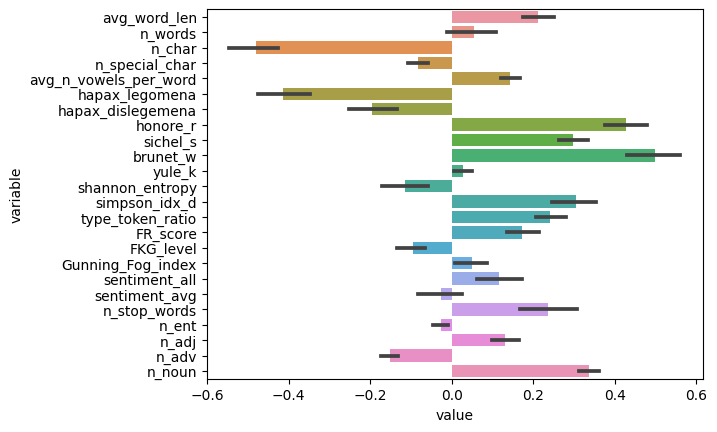

In [17]:
df_coefs = pd.DataFrame(m)
df_coefs.columns = col_use
sns.barplot(data=df_coefs.melt(), y="variable", x="value")
plt.show()

In [22]:
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=0)

In [25]:
out, m = run_experiment(X_train_u[col_use], y_train_u, cv_fold, clf_rf, False)
print(
    'styllsitic f rf    ',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

styllsitic f rf     Accuracy 0.515+-0.053 F1 Score 0.565+-0.055  0.515+-0.053 | 0.565+-0.055


In [26]:
clf_xgb = XGBClassifier(eval_metric='mlogloss', n_estimators=500, max_depth=5, learning_rate=0.001)

In [27]:
out, m = run_experiment(X_train_u[col_use], y_train_u, cv_fold, clf_xgb, False)
print(
    'styllsitic f xgb   ',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

styllsitic f xgb    Accuracy 0.522+-0.043 F1 Score 0.547+-0.064  0.522+-0.043 | 0.547+-0.064


In [18]:
out, m = run_experiment(X_train_u[col_use], y_train_u, cv_Kfold, clf_lr_1)
print(
    'styllsitic f lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)

100%|██████████| 10/10 [00:00<00:00, 58.05it/s]

styllsitic f lr C1 Accuracy 0.536+-0.053 F1 Score 0.526+-0.065  0.536+-0.053 | 0.526+-0.065


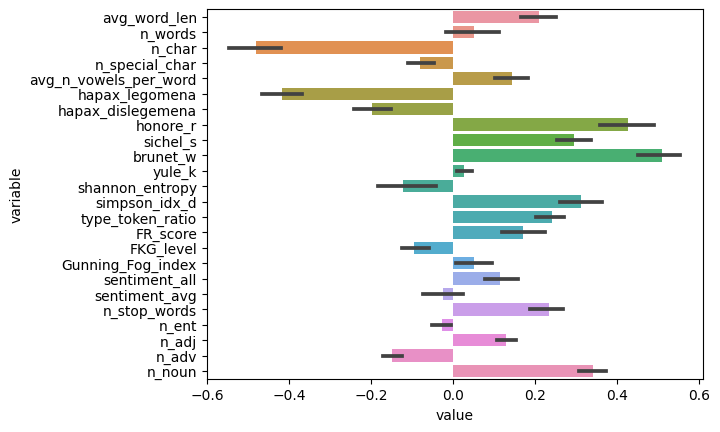

In [19]:
df_coefs = pd.DataFrame(m)
df_coefs.columns = col_use
sns.barplot(data=df_coefs.melt(), y="variable", x="value")
plt.show()